## General information

This notebook is the final project in the Workshop In Data Science course at Tel-Aviv university on 2018/19 academic year. 
The goal of this project is to predict Major League Baseball game attendance.
It contains all phases of the project - from cleaning to evaluation.

The project was done by:
Ran Erez, 
Eidan Wasser, 
Elkana Gamliel and
Dana Rapoport

![](https://upload.wikimedia.org/wikipedia/commons/9/98/Angels_Stadium.JPG)

### Importing libraries and getting data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std
import numpy.ma as ma
import csv
import math
import copy
from bisect import bisect_left as bisect
!pip install tqdm
from tqdm import tqdm
from IPython.display import HTML
from collections import defaultdict
from datetime import date, datetime
import seaborn as sns
from pandas.api.types import CategoricalDtype
from pandas.tools import plotting
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
data = pd.read_csv("GL1990_2017.csv")

## Dataset analysis

We have a really interesting dataset which contains MLB log games between 1990 to 2017!
Now let's have a look at the data itself. We can see trends, distributions and correlations.

In [3]:
pd.set_option('display.max_columns', 200)
data.head()

,season,date,number_of_game,day_of_week,visiting_team,visiting_team_league,visiting_team_game_number,home_team,home_team_league,home_team_game_number,visiting_team_runs,home_team_runs,game_time,completion_info,park_id,attendance,visiting_team_hits,visiting_team_home_runs,home_team_hits,home_team_home_runs,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,game_winning_rbi_batter_id,game_winning_rbi_batter_name,visiting_pitcher_id,visiting_pitcher_name,home_pitcher_id,home_pitcher_name,visiting_player1_id,visiting_player1_name,visiting_player1_pos,visiting_player2_id,visiting_player2_name,visiting_player2_pos,visiting_player3_id,visiting_player3_name,visiting_player3_pos,visiting_player4_id,visiting_player4_name,visiting_player4_pos,visiting_player5_id,visiting_player5_name,visiting_player5_pos,visiting_player6_id,visiting_player6_name,visiting_player6_pos,visiting_player7_id,visiting_player7_name,visiting_player7_pos,visiting_player8_id,visiting_player8_name,visiting_player8_pos,visiting_player9_id,visiting_player9_name,visiting_player9_pos,home_player1_id,home_player1_name,home_player1_pos,home_player2_id,home_player2_name,home_player2_pos,home_player3_id,home_player3_name,home_player3_pos,home_player4_id,home_player4_name,home_player4_pos,home_player5_id,home_player5_name,home_player5_pos,home_player6_id,home_player6_name,home_player6_pos,home_player7_id,home_player7_name,home_player7_pos,home_player8_id,home_player8_name,home_player8_pos,home_player9_id,home_player9_name,home_player9_pos,acquisition_info
0,1990,4/9/1990,0,Mon,DET,AL,1,BOS,AL,1,2,5,D,NaN,BOS07,35199.0,5,0,8,0,clemr001,Roger Clemens,morrj001,Jack Morris,smitl001,Lee Smith,evand002,Dwight Evans,morrj001,Jack Morris,clemr001,Roger Clemens,philt001,Tony Phillips,5,trama001,Alan Trammell,6,whitl001,Lou Whitaker,4,fielc001,Cecil Fielder,3,mosel001,Lloyd Moseby,8,nokem001,Matt Nokes,2,wardg001,Gary Ward,7,lemoc001,Chet Lemon,9,bergd001,Dave Bergman,10,boggw001,Wade Boggs,5,barrm001,Marty Barrett,4,greem001,Mike Greenwell,7,burke001,Ellis Burks,8,evand002,Dwight Evans,10,robib001,Billy Jo Robidoux,3,penat001,Tony Pena,2,reedj003,Jody Reed,6,romik001,Kevin Romine,9,Y
1,1990,4/9/1990,0,Mon,SEA,AL,1,CAL,AL,1,7,4,N,NaN,ANA01,38406.0,15,1,5,1,holmb001,Brian Holman,blylb001,Bert Blyleven,schom001,Mike Schooler,grifk002,Ken Griffey,holmb001,Brian Holman,blylb001,Bert Blyleven,reynh001,Harold Reynolds,4,grifk002,Ken Griffey,8,davia002,Alvin Davis,10,leonj001,Jeffrey Leonard,9,obrip001,Pete O'Brien,3,brilg001,Greg Briley,7,marte001,Edgar Martinez,5,valld001,Dave Valle,2,gileb001,Brian Giles,6,whitd001,Devon White,8,ray-j001,Johnny Ray,4,joynw001,Wally Joyner,3,davic001,Chili Davis,10,bichd001,Dante Bichette,7,washc001,Claudell Washington,9,parrl001,Lance Parrish,2,schur001,Rick Schu,5,mclem001,Mark McLemore,6,Y
2,1990,4/9/1990,0,Mon,MIL,AL,1,CHA,AL,1,1,2,D,NaN,CHI10,40008.0,4,0,6,0,joneb002,Barry Jones,fosst001,Tony Fossas,thigb001,Bobby Thigpen,flets001,Scott Fletcher,bosic001,Chris Bosio,perem001,Melido Perez,shefg001,Gary Sheffield,5,surhb001,B.J. Surhoff,2,younr001,Robin Yount,8,parkd001,Dave Parker,10,deerr001,Rob Deer,9,brocg001,Greg Brock,3,bragg001,Glenn Braggs,7,diaze001,Edgar Diaz,6,bateb001,Billy Bates,4,johnl001,Lance Johnson,8,flets001,Scott Fletcher,4,caldi001,Ivan Calderon,7,walkg001,Greg Walker,10,fiskc001,Carlton Fisk,2,martc002,Carlos Martinez,3,ventr001,Robin Ventura,5,sosas001,Sammy Sosa,9,guilo001,Ozzie Guillen,6,Y
3,1990,4/9/1990,0,Mon,BAL,AL,1,KCA,AL,1,7,6,D,NaN,KAN06,37671.0,14,2,10,2,aldrj001,Jay Aldrich,montj002,Jeff Montgomery,olsog001,Gregg Olson,NaN,(none),milab001,Bob Milacki,sabeb001,Bret Saberhagen,bradp001,Phil Bradley,7,orsuj001,Joe Orsulak,9,ripkc001,Cal Ripken,6,tettm001,Mickey Tettleton,2,millr002,Randy Milligan,3,horns001,Sam Horn,10,wortc001,Craig Worthington,5,devem001,Mike Devereaux,8,ripkb001,Billy Ripken,4,perrg001,Gerald Perry,10,seitk001,Kevin Seitzer,5,bretg001,Geor

In [4]:
print("original dimensions", data.shape)

original dimensions (65322, 87)


<font color=blue>__attendance distribution__</font>

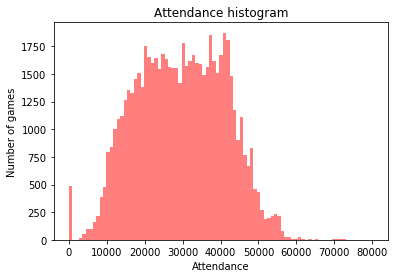

In [5]:
data['attendance'].hist(grid = False, color = 'r', bins = 'auto', alpha=0.5)
plt.xlabel('Attendance')
plt.ylabel('Number of games')
plt.title('Attendance histogram')
plt.show()

we can see that we have about 500 games with 0 attendance

In [6]:
data[data['attendance']==0].head()

,season,date,number_of_game,day_of_week,visiting_team,visiting_team_league,visiting_team_game_number,home_team,home_team_league,home_team_game_number,visiting_team_runs,home_team_runs,game_time,completion_info,park_id,attendance,visiting_team_hits,visiting_team_home_runs,home_team_hits,home_team_home_runs,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,game_winning_rbi_batter_id,game_winning_rbi_batter_name,visiting_pitcher_id,visiting_pitcher_name,home_pitcher_id,home_pitcher_name,visiting_player1_id,visiting_player1_name,visiting_player1_pos,visiting_player2_id,visiting_player2_name,visiting_player2_pos,visiting_player3_id,visiting_player3_name,visiting_player3_pos,visiting_player4_id,visiting_player4_name,visiting_player4_pos,visiting_player5_id,visiting_player5_name,visiting_player5_pos,visiting_player6_id,visiting_player6_name,visiting_player6_pos,visiting_player7_id,visiting_player7_name,visiting_player7_pos,visiting_player8_id,visiting_player8_name,visiting_player8_pos,visiting_player9_id,visiting_player9_name,visiting_player9_pos,home_player1_id,home_player1_name,home_player1_pos,home_player2_id,home_player2_name,home_player2_pos,home_player3_id,home_player3_name,home_player3_pos,home_player4_id,home_player4_name,home_player4_pos,home_player5_id,home_player5_name,home_player5_pos,home_player6_id,home_player6_name,home_player6_pos,home_player7_id,home_player7_name,home_player7_pos,home_player8_id,home_player8_name,home_player8_pos,home_player9_id,home_player9_name,home_player9_pos,acquisition_info
24,1990,4/11/1990,1,Wed,SFN,NL,1,ATL,NL,1,8,0,N,NaN,ATL01,0.0,13,2,3,0,reusr001,Rick Reuschel,glavt001,Tom Glavine,NaN,(none),clarw001,Will Clark,reusr001,Rick Reuschel,glavt001,Tom Glavine,butlb001,Brett Butler,8,bassk001,Kevin Bass,9,clarw001,Will Clark,3,mitck001,Kevin Mitchell,7,willm003,Matt Williams,5,thomr003,Robby Thompson,4,cartg001,Gary Carter,2,uribj001,Jose Uribe,6,reusr001,Rick Reuschel,1,mcdoo001,Oddibe McDowell,8,treaj001,Jeff Treadway,4,gregt001,Tommy Gregg,7,esasn001,Nick Esasky,3,murpd001,Dale Murphy,9,white002,Ernie Whitt,2,presj001,Jim Presley,5,blauj001,Jeff Blauser,6,glavt001,Tom Glavine,1,Y
35,1990,4/12/1990,1,Thu,PHI,NL,2,CHN,NL,2,5,4,D,NaN,CHI11,0.0,7,0,9,1,mulht001,Terry Mulholland,wilss001,Steve Wilson,mcdor001,Roger McDowell,thond001,Dickie Thon,mulht001,Terry Mulholland,wilss001,Steve Wilson,camps001,Sil Campusano,8,herrt001,Tom Herr,4,martc001,Carmelo Martinez,7,jordr001,Ricky Jordan,3,hayev001,Von Hayes,9,thond001,Dickie Thon,6,lakes001,Steve Lake,2,hayec001,Charlie Hayes,5,mulht001,Terry Mulholland,1,waltj001,Jerome Walton,8,sandr001,Ryne Sandberg,4,mccll001,Lloyd McClendon,7,dawsa001,Andre Dawson,9,gracm001,Mark Grace,3,salal001,Luis Salazar,5,dunss001,Shawon Dunston,6,giraj001,Joe Girardi,2,wilss001,Steve Wilson,1,Y
293,1990,5/5/1990,1,Sat,SDN,NL,22,CHN,NL,22,2,3,D,NaN,CHI11,0.0,8,0,7,1,maddg002,Greg Maddux,leffc001,Craig Lefferts,NaN,(none),dunss001,Shawon Dunston,benea001,Andy Benes,maddg002,Greg Maddux,alomr001,Roberto Alomar,4,gwynt001,Tony Gwynn,9,cartj001,Joe Carter,8,clarj001,Jack Clark,3,lynnf001,Fred Lynn,7,santb001,Benito Santiago,2,robeb002,Bip Roberts,5,tempg001,Garry Templeton,6,benea001,Andy Benes,1,wynnm001,Marvell Wynne,8,sandr001,Ryne Sandberg,4,smitd003,Dwight Smith,9,gracm001,Mark Grace,3,clard001,Dave Clark,7,salal001,Luis Salazar,5,dunss001,Shawon Dunston,6,giraj001,Joe Girardi,2,maddg002,Greg Maddux,1,Y
300,1990,5/6/1990,1,Sun,TEX,AL,24,CLE,AL,23,5,9,D,NaN,CLE07,0.0,8,3,12,4,candt001,Tom Candiotti,bohab001,Brian Bohanon,orosj001,Jesse Orosco,baerc001,Carlos Baerga,bohab001,Brian Bohanon,candt001,Tom Candiotti,husoj001,Jeff Huson,6,palmr001,Rafael Palmeiro,3,franj002,Julio Franco,4,sierr001,Ruben Sierra,9,bainh001,Harold Baines,10,incap001,Pete Incaviglia,7,petrg001,Geno Petralli,2,cools001,Scott Coolbaugh,5,pettg001,Gary Pettis,8,websm001,Mitch Webster,8,browj001,Jerry Browne,4,baerc001,Carlos Baerga,5,sn

we can see that all the games with 0 attendence have 1 in column "number_of_game":

In [7]:
data.loc[(data['attendance'] == 0) & (data['number_of_game'] !=1)].shape

(0, 87)

this happens when there are 2 games in a row and the audience can stay in the stadium. We can ignore these rows of data. __Since we will later create new features, such as player's statistics, which are cumulative and we want to take into account all the games along a season, we will keep the original data as is and ignore the missing values only before modeling__.

In [8]:
data_for_modeling = data[data['attendance']!=0]

We also have 3 missing attendance values, since it is only 3 we will ignore them:

In [9]:
np.sum(data_for_modeling.isnull())

season                              0
date                                0
number_of_game                      0
day_of_week                         0
visiting_team                       0
visiting_team_league                0
visiting_team_game_number           0
home_team                           0
home_team_league                    0
home_team_game_number               0
visiting_team_runs                  0
home_team_runs                      0
game_time                           1
completion_info                 64801
park_id                             0
attendance                          3
visiting_team_hits                  0
visiting_team_home_runs             0
home_team_hits                      0
home_team_home_runs                 0
winning_pitcher_id                 13
winning_pitcher_name               13
losing_pitcher_id                  13
losing_pitcher_name                13
saving_pitcher_id               31965
saving_pitcher_name                 0
game_winning

In [10]:
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

## Initial Data enrichment and cleaning
The initial data is lacking very basic features, so let's get them.
<br>
_divisions_ - team's division (east/west/center) (categorical)
<br>
_loss count_ - the number of losses this season up until this game (numeric)
<br>
_park capacity_ - official number, attendance can sometimes be higher than the park capacity (numeric)

In [11]:
# @hidden_cell

def type_fix(df):
    """
    fix the types of the columns
    """
    for r in df:
        r['date'] = datetime.strptime(r['date'],'%m/%d/%Y').date()
        r['number_of_game'] = int(r['number_of_game'])
        r['visiting_team_game_number'] = int(r['visiting_team_game_number'])
        r['home_team_game_number'] = int(r['home_team_game_number'])
        r['visiting_team_runs'] = int(r['visiting_team_runs'])
        r['home_team_runs'] = int(r['home_team_runs'])
        r['visiting_team_hits'] = int(r['visiting_team_hits'])
        r['visiting_team_home_runs'] = int(r['visiting_team_home_runs'])
        r['home_team_hits'] = int(r['home_team_hits'])
        r['home_team_home_runs'] = int(r['home_team_home_runs'])
        
def fix_team_names(df):
    """
    for teams that have changed names at some point
    """
    teams = {'FLO':'MIA', 'CAL':'ANA'}
    for r in df:
        for team in ['home_team', 'visiting_team']:
            r[team] = teams.get(r[team], r[team])

def divisions(df):
    """
    add team's division to dataset from external integration.
    teams compete to be the team with the most wins in their deivision in order to reach playoffs
    """
    divisions = {}
    with open("divisions.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            divisions[int(r['season']), r['team']] = r['division']

    for r in df:
        for team in ['visiting_team', 'home_team']:
            r[team+'_division'] = divisions[r['season'], r[team]]

def loss_count(df):
    current_count = defaultdict(int)# holds the metric count per team / season up until a given point in time

    for r in df:
        r['winning_team'] = r['home_team'] if r['home_team_runs'] > r['visiting_team_runs'] else r['visiting_team'] # team with the most runs in the winner
        for team in ('home_team', 'visiting_team'):
            # enter value into dataset before computing the new value given this game's outcome
            r['{}_loss_count'.format(team)] = current_count[r['season'], r[team]]

            if r['winning_team'] != r[team]:
                current_count[r['season'], r[team]] += 1 #team lost, increment loss counter
                
def park_capacity(df):
    """
    add official park capacity from external integration
    note: attendance can sometimes be higher than the park capacity (added standing room for instance)
    """
    park_capacities = {}
    with open("park_capacities.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            park_capacities[int(r['season']), r['park_id']] = r['park_capacity']

    for r in df:
        r['park_capacity'] = park_capacities[r['season'], r['park_id']]

In [12]:
data_as_dict = data.to_dict("records")
type_fix(data_as_dict)
fix_team_names(data_as_dict)
divisions(data_as_dict)
loss_count(data_as_dict)
park_capacity(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

<font color=blue>__in-data correlation__</font>

We will show correlations only between some features (because of visibility reasons)

In [13]:
data1=data_for_modeling[['season','date','number_of_game','day_of_week','visiting_team','visiting_team_league','visiting_team_division','visiting_team_game_number','home_team','home_team_league','home_team_division','home_team_game_number','visiting_team_runs','home_team_runs','winning_team','visiting_team_loss_count','home_team_loss_count','game_time','park_id','park_capacity','attendance']]

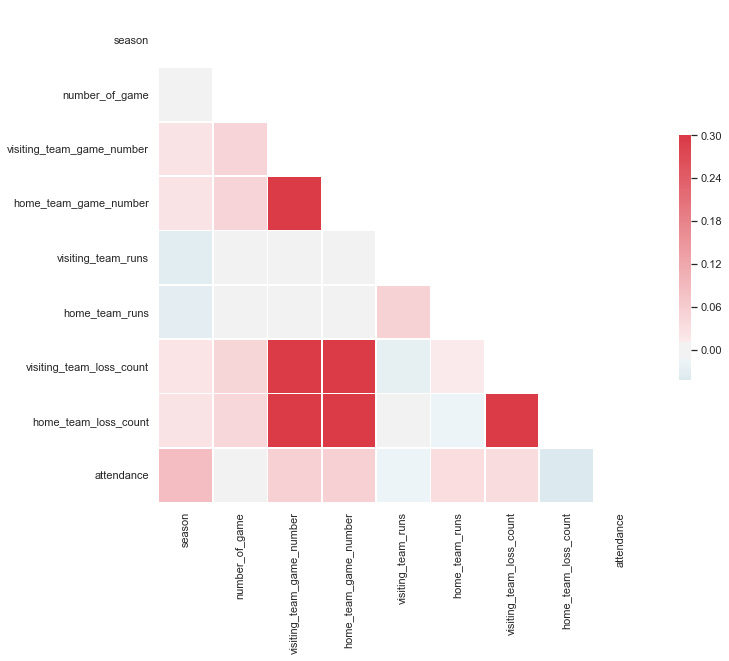

In [14]:
corr = data1.corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As can be seen in the last line of the table, no feature affects the attendance dramatically on its own

<font color=blue>__trends over time of week__</font>

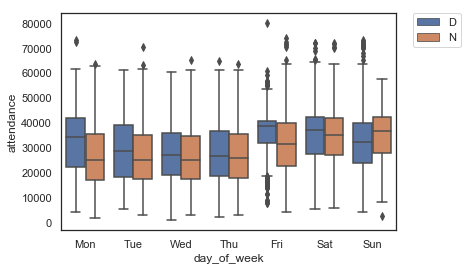

In [15]:
order = ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun']
data1 = data_for_modeling[['day_of_week','game_time','attendance' ]]
sns.boxplot(x='day_of_week', y='attendance',data=data1, order=order,hue='game_time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

we can see a slight difference between weekdays and weekends and between day (D) and night (N) games.

<font color=blue>__Home team influence__</font>

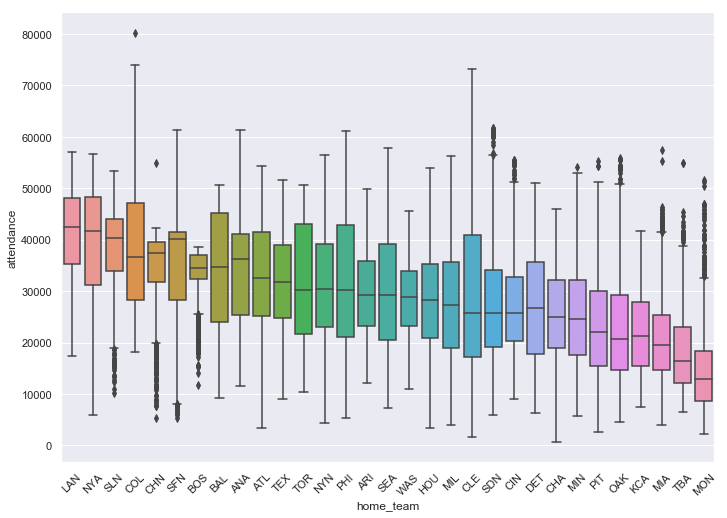

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
order = data_for_modeling.groupby(by=["home_team"])["attendance"].mean().sort_values()[::-1].index
ax = sns.boxplot(x='home_team', y='attendance', data=data_for_modeling, order = order)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

We can see a general trend along the home teams. We can also see that BOS has very little variance comparing to CLE.

## Modeling
### Basic data & basic models

We will start from one global parametric model - linear regression and one local nonparametric model - KNN regression.
We drop all the 'after game time' variables which obviously did not influence the number of attendance (such as the winning team or the hit counts), we will convert all the categorical variables to one-hot encoding. 
__Since encoding the player's lineup variables result in a huge dimension, we will ignore the players for now and think of a way to reduce the dimensionality while still using this data.__

<font color=blue>__Linear regression__</font>

In [64]:
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team and home team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')
oh_home_team = pd.get_dummies(data_for_modeling['home_team'],prefix='home_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

Y = data_for_modeling["attendance"]

# drop post-game features and players ids and names
post_game_features_and_players = ['home_player9_id','home_player8_id','home_player7_id','home_player6_id','home_player5_id','home_player4_id',
             'home_player3_id','home_player2_id','home_player1_id','visiting_player9_id','visiting_player8_id','visiting_player7_id',
             'visiting_player6_id','visiting_player5_id','visiting_player4_id','visiting_player3_id','visiting_player2_id','visiting_player1_id',
             'home_pitcher_id','visiting_pitcher_id','park_id','home_team_division','visiting_team_division','home_team','visiting_team',
             'attendance','winning_team','completion_info','visiting_team_runs','home_team_runs','visiting_team_hits','visiting_team_home_runs','home_team_hits',
             'home_team_home_runs','home_team_home_runs','winning_pitcher_id','winning_pitcher_name','losing_pitcher_id',
             'losing_pitcher_name','saving_pitcher_id','saving_pitcher_name','game_winning_rbi_batter_id','game_winning_rbi_batter_name',
             'visiting_pitcher_name','home_pitcher_name','visiting_player1_name','visiting_player2_name','visiting_player3_name',
             'visiting_player4_name','visiting_player5_name','visiting_player6_name','visiting_player7_name','visiting_player8_name',
             'visiting_player9_name','home_player1_name','home_player2_name','home_player3_name','home_player4_name',
             'home_player5_name','home_player6_name','home_player7_name','home_player8_name','home_player9_name','acquisition_info',
             'visiting_pitcher_id','home_pitcher_id','visiting_player1_id','visiting_player2_id','visiting_player3_id','visiting_player3_id',
             'visiting_player4_id','visiting_player5_id','visiting_player6_id','visiting_player7_id','visiting_player8_id','visiting_player9_id',
             'home_player1_id','home_player2_id','home_player3_id','home_player4_id','home_player5_id','home_player6_id','home_player7_id',
             'home_player8_id','home_player9_id']
X = data_for_modeling.drop(post_game_features_and_players,axis=1)
X = pd.concat([X,oh_visiting_team,oh_home_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [65]:
print("data dimensions after first enrichment and one-hot encoding", X.shape)

data dimensions after first enrichment and one-hot encoding (64836, 160)


In [66]:
lm = linear_model.LinearRegression()
score = cross_val_score(lm, X, Y, cv=10, scoring='neg_mean_squared_error')
print ("The RMSE score for 10-fold cross validation is ", np.sqrt(score.mean()*-1))
lm.fit(X,Y)
print ("The R^2 score is ", lm.score(X,Y))

The RMSE score for 10-fold cross validation is  8834.238224103705
The R^2 score is  0.4815372999668064


In [67]:
res = feature_selection.f_regression(X, Y)
params = pd.Series(res[1], index=X.columns)
print("the most significant features are: (p-values)")
print(params.sort_values()[:10])
print("the least significant features are:(p-values)")
print(params.sort_values()[-10:])

the most significant features are: (p-values)
home_team_NYA     0.000000e+00
home_team_LAN     0.000000e+00
home_team_MON     0.000000e+00
home_team_TBA     0.000000e+00
park_id_MON02     0.000000e+00
park_id_LOS03     0.000000e+00
day_of_week       0.000000e+00
park_id_STP01     0.000000e+00
home_team_SLN    1.751128e-289
home_team_MIA    6.880876e-276
dtype: float64
the least significant features are:(p-values)
park_id_MNT01               0.280393
park_id_SYD01               0.292785
home_player1_pos            0.314740
park_id_ATL03               0.344728
park_id_SAN02               0.385980
visiting_team_division_E    0.464431
home_team_SEA               0.471358
visiting_player5_pos        0.645760
home_player6_pos            0.871319
visiting_team_OAK           0.968143
dtype: float64


<font color=blue>__KNN regression__</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:23<00:00, 45.92s/it]


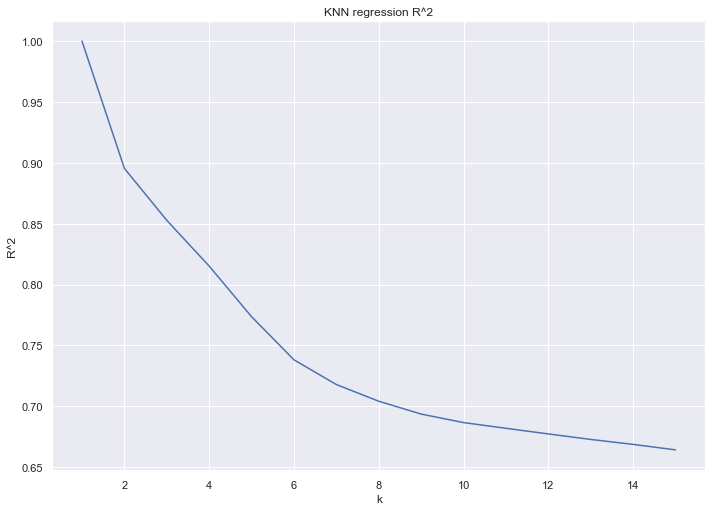

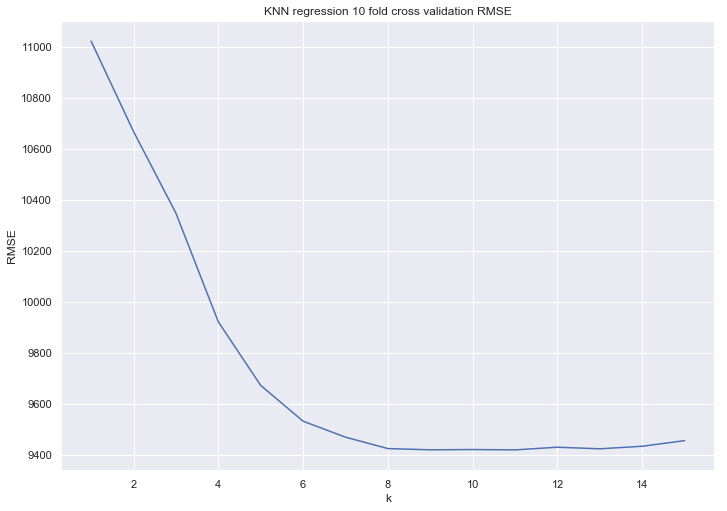

the best result is for K= 11  with RMSE =  9419.517857958823  and R^2 =  0.6818207382263568


In [68]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]

for i in tqdm(range(1,16)):
    neigh = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(neigh, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i-1] = np.sqrt(score.mean()*-1)
    neigh.fit(X,Y)
    r2[i-1] = neigh.score(X,Y)
    
plt.plot([i for i in range(1,16)],r2)
plt.ylabel('R^2')
plt.xlabel('k')
plt.title('KNN regression R^2')
plt.show()

plt.plot([i for i in range(1,16)],rmse)
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('KNN regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for K=", best+1, " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

As can be seen, both linear and KNN regression do not perform very well. We need to integrate external data and engineer new features.

## Feature Engineering
__Integrations__: 
<br>
- _holidays_ - 1 if Opening Day (first home game of the year), July 4th (in US), Labor Day, Memorial Day, Canada day (in Canada) (boolean)
<br>
- _rivalry_  - 1 if the game is between local/historic rivals. For instance 2 teams from the same city or the famous New York Yankees vs Boston Red Sox (boolean)
<br>
- _weather_  - 3 new features: wind speed, temperture and condition score (enumeration of weather condition. no clouds/in dome=0, cloudy/overcast=1, rain=3,snow/hail=5) (numeric)
<br>
- _salary_ - 3 new features (for each team): yearly max and avarege salary of lineup players and starting pitcher salary. Normalized against all salaries in a given season. (numeric)

__Feature Engineering__:
<br>
- _streaks_  - number of winning(positive)/lossing(negative) games in a row until the current game for each team(numeric)
<br>
- _intradivision_ - 1 if game was between two teams from the same division and league, 0 otherwise (boolean)
<br>
- _interleague_ - 1 if the game is between teams from opposite leagues. (boolean) 
<br>
- _players statistics_ - 6 new features (for each team): max slugging percentage, avarege slugging percentage, max on-base plus slugging, avarege on-base plus slugging, starting pitcher earned run average, starting pitcher win probability added. All the features are normalized against all other player's statistcs for that game number, in that season. These features are meant to indicate the presence of "star" players and overall team gameplay quality (numeric)
<br>
- _games behind_ - difference in number of losses between a given team and the first place team in its division, for each team(numeric)
<br>
- _rank in division_ - team's rank (1st/2nd,3rd…) in its division prior to the game, for each team (numeric)

In [69]:
# @hidden_cell

def normalize(pop, val, cache=None,key=None):
    if val is None:
        return 0
    if cache is not None:
        if key not in cache:
            cache[key] = mean(pop), std(pop)
        m,s = cache[key]
    else:
        m,s = mean(pop), std(pop)
    return (val - m)/s if s else 0

def streaks(df):
    """
    calculate winning/losing streak. How many games in a row has the team won / lost up until the current game.
    """
    current_streak = defaultdict(int) # holds the streak per team up until a given point in time
    for r in df:
        for team in ('home_team', 'visiting_team'):
            # enter value into dataset before computing the new value given this game's outcome
            r[team+'_streak'] = current_streak[r['season'], r[team]]

            if r['winning_team']==r[team]:# team won
                if current_streak[r['season'],r[team]] > 0: # team is on a winning streak, increment it
                    current_streak[r['season'], r[team]]+=1
                else:
                    current_streak[r['season'], r[team]]=1 # team was on a losing streak, nullify it
            else: # team lost
                if current_streak[r['season'], r[team]] < 0: # team is on a losing streak, increment it
                    current_streak[r['season'], r[team]] -= 1
                else:
                    current_streak[r['season'], r[team]] = -1 # team was on a winning streak, nullify it

def cumulative_metric(df,metric):
    current_count = defaultdict(int) # holds the metric count per team / season up until a given point in time
    norm = defaultdict(list) # all values to be used to normalize the feature

    for r in df:
        for team in ('home_team', 'visiting_team'):
            # enter value into dataset before computing the new value given this game's outcome
            r['cumulative_{}_{}'.format(team,metric)] = current_count[r['season'], r[team]]

            norm[r['season'], r[team+'_game_number']].append(current_count[r['season'], r[team]])
            current_count[r['season'], r[team]] += r['_'.join([team,metric])]

    norm_cache = {}
    for r in df:
        for team in ('home_team', 'visiting_team'):
            if r[team+'_game_number'] > 10: # don't calculate this field if there haven't been enough games played this season. not enough data
                pop = norm[r['season'], r[team+'_game_number']] #population to normalize against
                r['cumulative_{}_{}_normalized'.format(team, metric)] = normalize(pop,r['cumulative_{}_{}'.format(team,metric)], norm_cache, (r['season'], r[team+'_game_number']))
            else:
                r['cumulative_{}_{}_normalized'.format(team, metric)] = 0
                
def intradivision(df):
    """
    1 if both game was between two teams from the same division and league, 0 otherwise.
    Teams in the same division compete with each other for a single playoff berth, but also play far
    more games between one another
    """
    for r in df:
        r['is_intradivision'] = r['visiting_team_league']==r['home_team_league'] and \
            r['visiting_team_division']==r['home_team_division']
        
def interleague(df):
    """
    1 if the game is between teams from opposite divisions.
    These games are more rare and thus fans tend to find them moree interesting
    """
    for r in df:
        r['interleague'] = r['visiting_team_league'] != r['home_team_league']
        
def holiday(df):
    """
    1 if Opening Day (first home game of the year), July 4th (in US), Labor Day, Memorial Day, Canada day (in Canada)
    """
    holidays = set()
    with open("holidays.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            dt = datetime.strptime(r['date'], '%m/%d/%Y').date()
            holidays.add((dt, r['home_team']))

    for r in df:
        r['holiday'] = (r['date'], r['home_team']) in holidays
        
def rivalry(df):
    """
    1 if the game is between local/historic rivals.
    For instance 2 teams from the same city or the famous New York Yankees vs Boston Red Sox
    get from external integration.
    """
    rivalries = set()
    with open("rivalries.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            rivalries.add((r['visiting_team'], r['home_team']))

    for r in df:
        r['rivalry'] = ((r['visiting_team'], r['home_team'])) in rivalries

def get_condition_score(conditions, percip):
    """
    condition_score = 0 -> best conditions
    high condition_score -> bad conditions
    """

    if conditions == 'in dome': # dome = controlled climate
        return 0

    percip_score = {
        'no precipitation': 0,
        'drizzle': 3,
        'showers': 4,
        'rain': 5,
        'snow': 7
    }
    condition_score = {
        'night': 0,
        'sunny': 0,
        'cloudy': 1,
        'overcast': 1,
    }

    if percip not in ('null', 'unknown'):
        if percip_score[percip] > 0: # if there was percipitation, decide condition score based on that
            return percip_score[percip]

    if conditions not in ('null', 'unknown'): # no/unknown percipitation, use condition data instead
        return condition_score[conditions]
    else:
        return None # no data exists

def month(date):
    # almost no games in mar or oct. estimate using apr / sep respectively
    if date.month == 3:
        return 4
    if date.month == 10:
        return 9
    return date.month

defaults = { #domed stadiums. if the conditions are missing, default to 0.
    ('MIA02', 'wind'): 0,
    ('STP01', 'wind'): 0,
    ('PHO01', 'oondition_score'): 0,
    ('HOU02', 'oondition_score'): 0,
    ('HOU03', 'oondition_score'): 0,
    ('MIA02', 'oondition_score'): 0,
    ('MON02', 'oondition_score'): 0,
    ('SEA02', 'oondition_score'): 0,
    ('SEA03', 'oondition_score'): 0,
    ('TOR02', 'oondition_score'): 0,
    ('STP01', 'oondition_score'): 0,
    ('MIN04', 'oondition_score'): 0,
}

def weather(df):
    """
    weather exxternal integration.
    temp: temprature (F) at the start of the game in the stadium. If the stadium is domed, use indoor temrature
    wind: wind speed (mph) at the start of the game in the stadium. If the stadium is domed wind=0
    condition_score: enumeration of weather condition. no clouds/in dome=0, cloudy/overcast=1, rain=3-5,snow/hail=7
    """
    weather_data = {} # to hold weather data per game
    norm = defaultdict(list) # use means (per team, month) for missing values
    with open("weather.csv") as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            dt = datetime.strptime(r['date'],'%m/%d/%Y').date()
            condition_score = get_condition_score(r['conditions'], r['percip'])

            #convert data from strings
            r['temp'] = int(r['temp']) if r['temp'] != 'null' else None
            r['wind_speed'] = int(r['wind_speed']) if r['wind_speed'] != 'null' else None

            weather_data[dt, r['home']] = {'temp': r['temp'],
                                                  'wind': r['wind_speed'],
                                                  'condition_score': condition_score}
            if r['temp'] is not None:
                norm['temp', month(dt), r['home']].append(r['temp'])
                norm['temp'].append(r['temp'])
            if r['wind_speed'] is not None:
                norm['wind', month(dt), r['home']].append(r['wind_speed'])
                norm['wind'].append(r['wind_speed'])
            if condition_score is not None:
                norm['condition_score', month(dt), r['home']].append(condition_score)
                norm['condition_score'].append(condition_score)

    for r in df:
        for metric in ['temp', 'wind', 'condition_score']:
            """
            get weather data from:
             - actual value from weather data if it exists there, or
             - default value if this is a domed stadium, or
             - average weather metric for that city/month if there are more than 4 entries to  compute the sum with, or
             - overall average weather metric (treatment for missing value)
            """
            r[metric] = weather_data[r['date'], r['home_team']][metric] or \
                        defaults.get((metric, r['park_id'])) or \
                        (mean(norm[metric, month(r['date']), r['home_team']])
                         if len(norm[metric, month(r['date']), r['home_team']]) > 4
                         else mean(norm[metric]))

teams = {
'arizona_diamondbacks':'ARI',
'montreal_expos':'MON',
'florida_marlins':'MIA',
'anaheim_angels':'ANA',
'california_angels':'ANA',
'st._louis_cardinals':'SLN',
'tampa_bay_rays':'TBA',
'tampa_bay_devil_rays':'TBA',
'los_angeles_angels_of_anaheim':'ANA',
'baltimore_orioles':'BAL',
'boston_red_sox':'BOS',
'cincinnati_reds':'CIN',
'houston_astros':'HOU',
'los_angeles_dodgers':'LAN',
'milwaukee_brewers':'MIL',
'minnesota_twins':'MIN',
'new_york_mets':'NYN',
'oakland_athletics':'OAK',
'texas_rangers':'TEX',
'washington_nationals':'WAS',
'chicago_white_sox':'CHA',
'los_angeles_angels':'ANA',
'colorado_rockies':'COL',
'detroit_tigers':'DET',
'philadelphia_phillies':'PHI',
'pittsburgh_pirates':'PIT',
'san_diego_padres':'SDN',
'chicago_cubs':'CHN',
'kansas_city_royals':'KCA',
'new_york_yankees':'NYA',
'seattle_mariners':'SEA',
'san_francisco_giants':'SFN',
'cleveland_indians':'CLE',
'miami_marlins':'MIA',
'toronto_blue_jays':'TOR',
'atlanta_braves':'ATL',

}

player_outliers = {
    'rob macko':'rob mackowiak',
    'fausto carmona':'roberto hernandez',
    'tim vanegmond':'tim van egmond',
    'leo nunez':'juan carlos oviedo'
}

def get_stats(player_data,date,vis_team,home_team,player,pos):
    """
    find player stats in player stat data structure
    """
    date = str(date)
    try:
        return player_data[(date, vis_team, home_team,pos)][player]
    except KeyError: # player name does not exist in integration data
        try:
            if player in player_outliers: # some players have completely different names in the integration data
                return player_data[(date, vis_team, home_team,pos)][player_outliers[player]]
            return player_data[(date, vis_team, home_team,pos)][player.split(' ')[-1]] #try using only last name
        except KeyError:
            #print("{dt},{vs}-{home}: unable to locate {pl}".format(dt=date, vs=vis_team, home=home_team,pl=player))
            return [None]*4 # player is missing

def player_stats(df):
    """
    integrate player offensive/defensive stats. calculate and normalize max, avergae stats per team.
    slg: season start-to-date Slugging percentage of the offensive players in the lineup. A popular in-game metric
        for assesing an offensive player's run contribution.
    ops: season start-to-date On-Base Percentage + Slugging percentage of the offensive players in the lineup.
        A popular in-game metric for assesing an offensive player's overall offensive quality.
    wpa: season start-to-date Win Probability Added of the starting pitcher.
        A complex in-game metric for assesing how much the pitcher helped/ruined the team's chance of winning a game.
    era: season start-to-date Earned Run Average of the starting pitcher.
        A popular in-game metric for assesing the quality of a pitcher.
    """
    skip_header=True
    player_data = defaultdict(dict)
    with open("game_ranks.csv") as fp:
        reader = csv.reader(fp)
        for row in reader:
            if skip_header:
                skip_header = False
            else:
                date, vis_team, home_team, player_id, player_name, slg, ops, era, wpa, is_pitcher,yy = row
                slg = float(slg) if slg != '' else None
                ops = float(ops) if ops != '' else None
                era = float(era) if era != '' else None
                wpa = float(wpa) if wpa != '' else None
                player_name=' '.join(player_name.split('_'))
                player_last_name = player_name.split(' ')[-1]
                player_data[(date,teams[vis_team],teams[home_team],is_pitcher)][player_name] = [slg, ops, era, wpa]
                player_data[(date, teams[vis_team], teams[home_team],is_pitcher)][player_last_name] = [slg, ops, era, wpa]

    games = defaultdict(dict)
    norm = defaultdict(list)

    for r in df:
        for team in ['visiting', 'home']:
            if int(r['number_of_game']) < 2:

                date = r['date']
                pitcher = r[team+'_pitcher_name'].lower()
                players = [r[team+'_player{}_name'.format(i)].lower() for i in range(1,10)]

                games[(date, r[team+'_team'])]['pitcher'] = get_stats(player_data,date,r['visiting_team'],r['home_team'],pitcher,'1')
                games[(date, r[team+'_team'])]['positions'] = [get_stats(player_data,date,r['visiting_team'],r['home_team'],pl,'0') for pl in players]
                try:
                    pitcher = games[(date,r[team+'_team'])]['pitcher']
                    if pitcher[2]: norm['era',r['season']].append(pitcher[2])
                    if pitcher[3]: norm['wpa',r['season']].append(pitcher[3])
                except:
                    print((date,r[team+'_team'],'pitcher'))
                try:
                    pos = games[(date, r[team + '_team'])]['positions']
                    norm['slg',r['season']].extend([pos[p][0] for p in range(9) if pos[p] and pos[p][0]])
                    norm['ops',r['season']].extend([pos[p][1] for p in range(9) if pos[p] and pos[p][1]])
                except:
                    print((date, r[team + '_team'], 'positions'))
    norm_cache = {}
    for i,r in enumerate(df):
        for team in ['home_team', 'visiting_team']:
            if int(r[team+'_game_number']) > 10:
                players = games[r['date'], r[team]]

                r[team+'_starter_era_normalized'] = normalize(norm['era',r['season']], players['pitcher'][2], norm_cache, ('era',r['season']))
                r[team+'_starter_wpa_normalized'] = normalize(norm['wpa',r['season']], players['pitcher'][3], norm_cache, ('wpa',r['season']))

                normalized_ops = [normalize(norm['ops', r['season']], p[1], norm_cache, ('ops', r['season'])) for p in players['positions'] if p]
                normalized_slg = [normalize(norm['slg', r['season']], p[0], norm_cache, ('slg', r['season'])) for p in players['positions'] if p]
                try:
                    r[team+'_max_slg_normalized'] = max(normalized_slg)
                except ValueError:
                    r[team + '_max_slg_normalized'] = 0
                try:
                    r[team + '_max_ops_normalized'] = max(normalized_ops)
                except ValueError:
                    r[team + '_max_ops_normalized'] = 0
                try:
                    r[team + '_avg_slg_normalized'] = mean(normalized_slg)
                except ValueError:
                    r[team + '_avg_slg_normalized'] = 0
                try:
                    r[team + '_avg_ops_normalized'] = mean(normalized_ops)
                except ValueError:
                    r[team + '_avg_ops_normalized'] = 0
            else:
                r[team + '_max_slg_normalized'] = 0
                r[team + '_max_ops_normalized'] = 0
                r[team + '_avg_slg_normalized'] = 0
                r[team + '_avg_ops_normalized'] = 0
                r[team + '_starter_era_normalized'] = 0
                r[team + '_starter_wpa_normalized'] = 0


def salary(df):
    """
    average player yearly salary for each player in the starting lineup.
    Player salaries are an indicator for how much an organization expects for a player to drive revenues - a part of which are generated from attendance
    """
    salaries = {}
    salaries_by_last_name = defaultdict(dict)
    norm = defaultdict(list)
    with open("salaries_integration.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            salary = int(r['salary'])
            player = player_outliers.get(r['player'], r['player'])
            salaries[r['season'], r['team'], player] = salary
            salaries_by_last_name[int(r['season']), r['team'], player.split()[-1]] = salary
            norm[int(r['season'])].append(salary)

    def find_player_salary(record, team, player):
        return salaries.get((record['season'], record[team+'_team'], player.lower()),
                      salaries_by_last_name.get((record['season'], record[team+'_team'], player.lower().split()[-1]),0))
    norm_cache = {}
    for r in df:
        for team in ('home', 'visiting'):
            starting_pitcher_salary = find_player_salary(r, team, r['{}_pitcher_name'.format(team)])
            lineup_salaries = []
            for i in range(1,10):
                player = r['{}_player{}_name'.format(team, i)]
                sal = find_player_salary(r, team, player)
                if sal:
                    normalized_salary = normalize(norm[r['season']],sal, norm_cache, r['season'])
                    lineup_salaries.append(normalized_salary)

            r[team + '_max_salary_normalized'] = max(lineup_salaries)
            r[team + '_avg_salary_normalized'] = mean(lineup_salaries)
            if starting_pitcher_salary:
                normalized_starting_pitcher_salary = normalize(norm[r['season']],starting_pitcher_salary, norm_cache, r['season'])
                r[team+'_starter_salary_normalized'] = normalized_starting_pitcher_salary
            else:
                r[team+'_starter_salary_normalized'] = 0
                

def standings(df):
    """
    calculate metrics related to the team's standing in the division bracket.
    games_behind: difference in number of losses between a given team and the first place team in its division.
        This represents how far a team is behind in the ranks, and how likely it is for a team to make the playoffs.
        If the team is in first place, games behind is the difference in the number of losses between the team and the second place team (a negative number)
    rank_in_division: team's rank (1st/2nd,3rd…) in its division prior to the game.
        At the end of the season, only the 1st team in the division goes to the playoffs
    """
    gr = defaultdict(dict) # hold number of games remaining in the season for each team by division, date
    divisions_loss_count = defaultdict(dict) # hold loss count for each team by division, date
    pct = defaultdict(dict) # hold win percentage (wins/games played) for each team by division, date
    current_standings = defaultdict(dict)
    current_pct = defaultdict(dict)
    current_gr = defaultdict(dict)

    dt = None
    season = None
    for r in df:
        if r['date'] != dt:
            # hold snapshot of standings for each day
            divisions_loss_count[dt] = copy.deepcopy(current_standings)
            pct[dt] = copy.deepcopy(current_pct)
            gr[dt] = copy.deepcopy(current_gr)

        if season != r['season']:
            # nullify standings for a new season
            current_standings = defaultdict(dict)
            current_pct = defaultdict(dict)
            current_gr = defaultdict(dict)

        dt = r['date']
        season = r['season']

        for team in ['visiting_team', 'home_team']:
            if int(r['number_of_game']) < 2:
                div = r[team+'_league'],r[team+'_division']
                # update current pcts
                current_pct[div][r[team]] = 1-round(r[team+'_loss_count']*1.0/(r[team+'_game_number']-1) if r[team+'_game_number'] > 1 else 0.5,3)
                #update current standings
                current_standings[div][r[team]] = r[team+'_loss_count']

            # update current games remaining
            current_gr[r[team]] = 163 - int(r[team+'_game_number'])

    divisions_loss_count[dt] = copy.deepcopy(current_standings)
    gr[dt] = copy.deepcopy(current_gr)
    pct[dt] = copy.deepcopy(current_pct)

    gr_by_rank = {} # to hold lists of grs for each team, division, date sorted by team rank
    pct_by_rank = {} # to hold lists of pcts for each team, division, date sorted by team rank
    for dt, std in divisions_loss_count.items():
        for div, losses in std.items():
            ls = list(losses.items())
            ls.sort(key=lambda x:x[1]) # sorted list of (team,loss counts) in a division
            gr_by_rank[(dt,*div)] = [gr[dt][x[0]] for x in ls]
            pct_by_rank[(dt, *div)] = [pct[dt][div][x[0]] for x in ls]

    # enter metrics into dataset
    for r in df:
        for team in ['home_team', 'visiting_team']:
            div_loss_vals = list(
                divisions_loss_count[r['date']][r[team + '_league'], r[team + '_division']].values())
            div_loss_vals.sort() # sorted list of loss counts in this teams division

            # if this is a doubleheader, use loss count from before game 1
            loss_cnt = r[team + '_loss_count']-1 if r['number_of_game'] == 2 and r[team + '_loss_count'] not in div_loss_vals else r[team + '_loss_count']
            rank = bisect(div_loss_vals, loss_cnt) + 1 # locate the team's loss count within the list of sorted loss counts. its index in the list (+1) is its rank

            try:
                gb = loss_cnt - div_loss_vals[0 if rank > 1 else 1] # games behind = loss count - contender loss count
            except IndexError:
                gb = 0
            r[team + '_rank_in_division'] = rank
            r[team + '_games_behind'] = gb

            # contender stats to be used to calculate contention score
            # contender = first place team if the current team is not in first place.
            # contender = second place team otherwise
            contender_rank = 0 if rank > 1 or len(pct_by_rank[r['date'], r[team+'_league'], r[team+'_division']])==1 else 1
            r[team + '_contender_pct'] = pct_by_rank[r['date'], r[team+'_league'], r[team+'_division']][contender_rank]
            r[team + '_contender_games_remaining'] = gr_by_rank[r['date'], r[team+'_league'], r[team+'_division']][contender_rank]

In [70]:
data_as_dict = data.to_dict("records")
weather(data_as_dict)
holiday(data_as_dict)
rivalry(data_as_dict)
interleague(data_as_dict)
intradivision(data_as_dict)
cumulative_metric(data_as_dict, 'runs')
cumulative_metric(data_as_dict, 'hits')
cumulative_metric(data_as_dict, 'home_runs')
streaks(data_as_dict)
standings(data_as_dict)
salary(data_as_dict)
player_stats(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

### Converting to prediction of bins
Since papers have found that an increase in 1000 spectators results in 10.74 annual hours of traffic delay, we have decided to focus on predicting MLB attendance by bins of 1000.

In [71]:
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))

## Modeling
### Augmented Data & basic models

In [72]:
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')
oh_home_team = pd.get_dummies(data_for_modeling['home_team'],prefix='home_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

Y = data_for_modeling['attendance_in_thousands']

X = data_for_modeling.drop(post_game_features_and_players+['attendance_in_thousands'],axis=1)
X = pd.concat([X,oh_visiting_team,oh_home_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [73]:
print("data dimensions after second enrichment and one-hot encoding", X.shape)

data dimensions after second enrichment and one-hot encoding (64836, 207)


<font color=blue>__Linear regression__</font>

In [74]:
lm = linear_model.LinearRegression()
score = cross_val_score(lm, X, Y, cv=10, scoring='neg_mean_squared_error')
print ("The RMSE score for 10-fold cross validation is ", np.sqrt(score.mean()*-1))
lm.fit(X,Y)
print ("The R^2 score is ", lm.score(X,Y))

The RMSE score for 10-fold cross validation is  8.043812509564486
The R^2 score is  0.5680814359643243


In [75]:
res = feature_selection.f_regression(X, Y)
params = pd.Series(res[1], index=X.columns)
print("the most significant features are: (p-values)")
print(params.sort_values()[:10])
print("the least significant features are:(p-values)")
print(params.sort_values()[-10:])

the most significant features are: (p-values)
park_id_MON02                     0.0
park_id_LOS03                     0.0
rivalry                           0.0
home_team_LAN                     0.0
home_team_rank_in_division        0.0
home_team_games_behind            0.0
home_team_NYA                     0.0
home_team_avg_slg_normalized      0.0
home_team_avg_ops_normalized      0.0
home_starter_salary_normalized    0.0
dtype: float64
the least significant features are:(p-values)
park_id_MNT01               0.291626
park_id_SYD01               0.302273
park_id_ATL03               0.331884
home_player1_pos            0.346083
park_id_SAN02               0.388342
home_team_SEA               0.448971
visiting_team_division_E    0.473277
visiting_player5_pos        0.632695
home_player6_pos            0.901998
visiting_team_OAK           0.944652
dtype: float64


Many of our new features are among the most significant ones!

<font color=blue>__Ridge regression__</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:01<00:00, 16.10s/it]


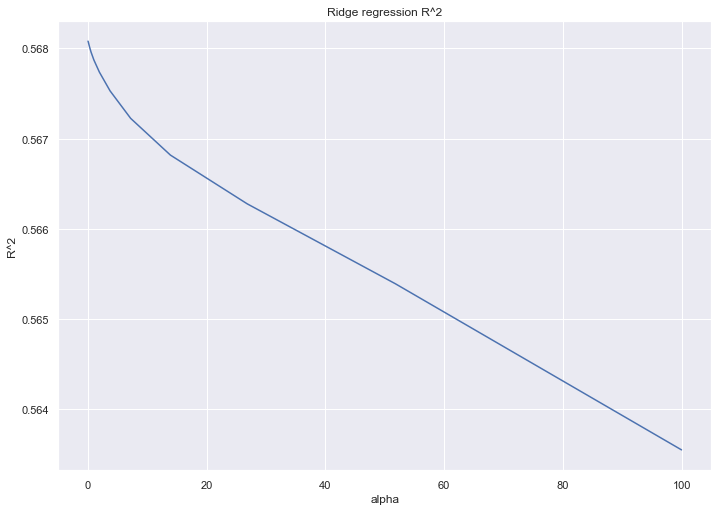

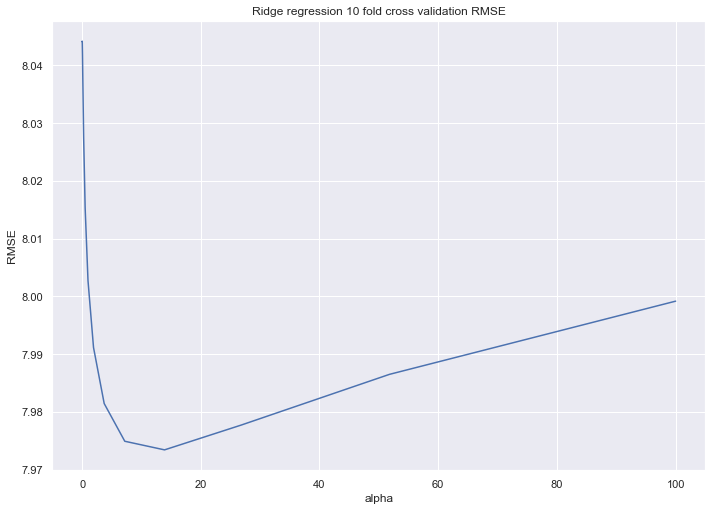

the best result is for alpha= 13.894954943731374  with RMSE =  7.973440058734529  and R^2 =  0.5668168346575784


In [76]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]
n_alphas = 15
alphas = np.logspace(-2, 2, n_alphas)

for i in tqdm(range(0,15)):
    ridg = Ridge(alpha = alphas[i])
    score = cross_val_score(ridg, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    ridg.fit(X,Y)
    r2[i] = ridg.score(X,Y)
    
plt.plot(alphas,r2)
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.title('Ridge regression R^2')
plt.show()

plt.plot(alphas,rmse)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.title('Ridge regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for alpha=", alphas[best], " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

<font color=blue>__Lasso regression__</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [16:57<00:00, 39.80s/it]


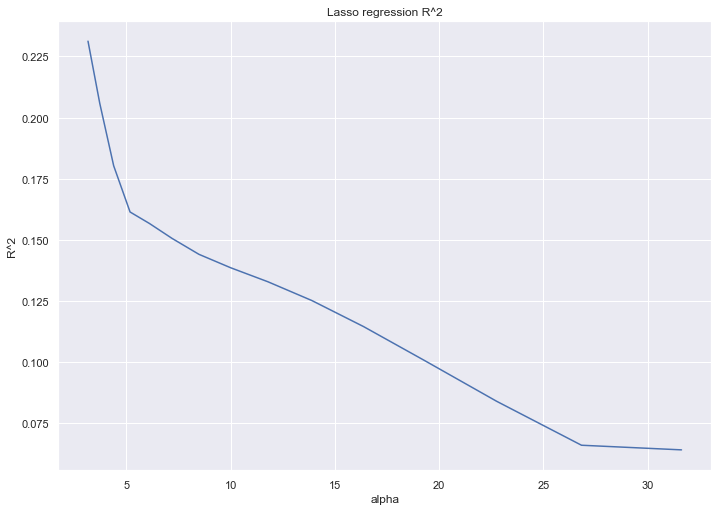

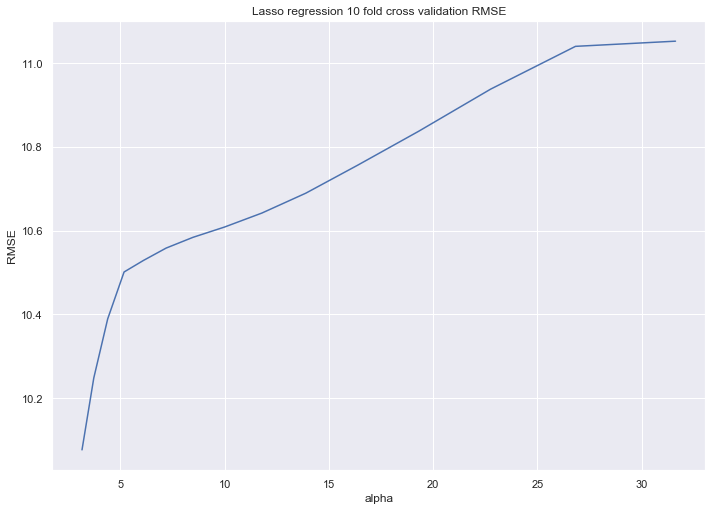

the best result is for alpha= 3.1622776601683795  with RMSE =  10.07616325412735  and R^2 =  0.23123853006754536


In [77]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]
n_alphas = 15
alphas = np.logspace(0.5,1.5, n_alphas)

for i in tqdm(range(0,15)):
    lass = Lasso(alpha = alphas[i])
    score = cross_val_score(lass, X, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    lass.fit(X,Y)
    r2[i] = lass.score(X,Y)
    
plt.plot(alphas,r2)
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.title('Lasso regression R^2')
plt.show()

plt.plot(alphas,rmse)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.title('Lasso regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for alpha=", alphas[best], " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

from both ridge and lasso, we understand that regularization does not improve our results. We will have to try different methods in order to reduce dimensionality.

<font color=blue>__KNN Classification__</font>

since we now predict in bins of 1K, we want to use classification instead of regression.
But some of the class are very small so we cannot use k-fold cross-validation.
We will implement semi-cross validation by randomly divide the data 10 times to train and test

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [16:05<00:00, 67.42s/it]


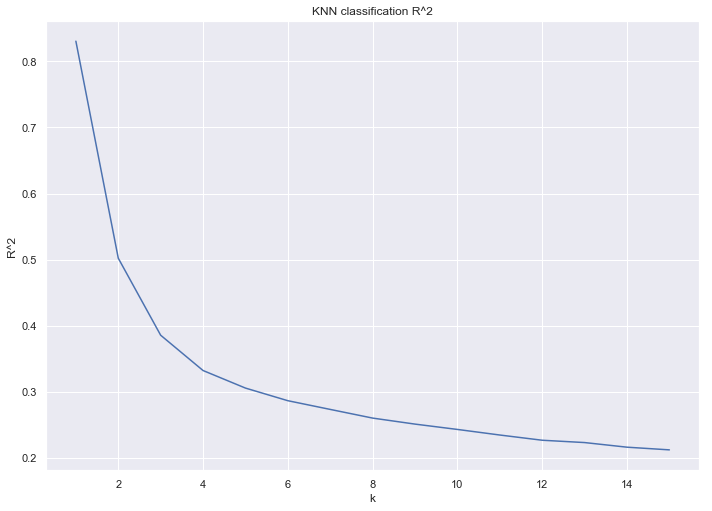

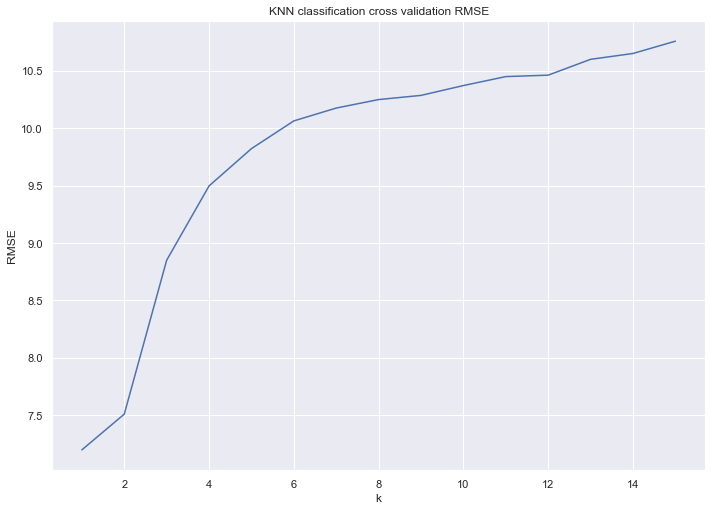

the best result is for k= 1  with RMSE =  7.197421260500716  and R^2 =  0.8304182861373312


In [78]:
r2=[0 for i in range(15)]
rmse=[0 for i in range(15)]

for i in tqdm(range(1,16)):
    score=[]
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train, y_train)
        pred = neigh.predict(X_test)
        pred = pd.DataFrame(pred)
        pred['round'] = pred[0]
        pred = pred['round']
        pred = pd.DataFrame(pred)
        y_test=pd.DataFrame(y_test)
        df1 = pd.DataFrame(y_test.attendance_in_thousands.tolist())
        df2 = pd.DataFrame(pred['round'].tolist())
        df = pd.concat([df1,df2],axis=1)
        df.columns=['a','b']
        score.append(((df['a']-df['b']) ** 2).mean() ** .5)
    rmse[i-1]= sum(score)/10
    r2[i-1] = neigh.score(X,Y)

plt.plot([i for i in range(1,16)],r2)
plt.ylabel('R^2')
plt.xlabel('k')
plt.title('KNN classification R^2')
plt.show()

plt.plot([i for i in range(1,16)],rmse)
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('KNN classification cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for k=", best+1, " with RMSE = ", rmse[best], " and R^2 = ", r2[best])

<font color=blue>__PCA and linear regression__</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.79s/it]


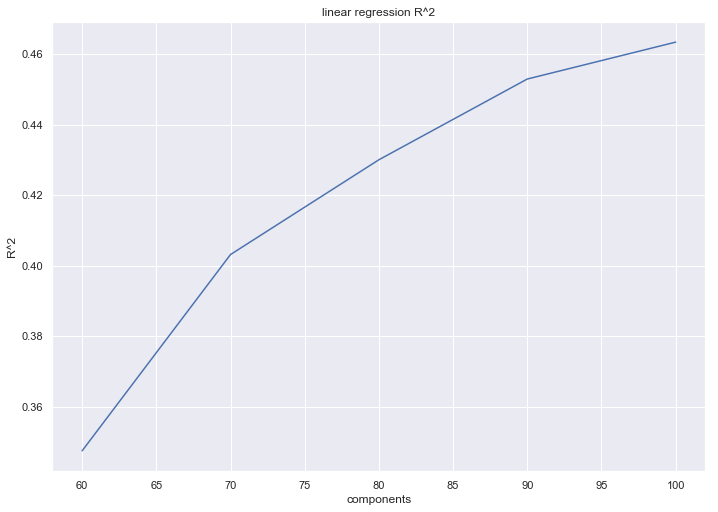

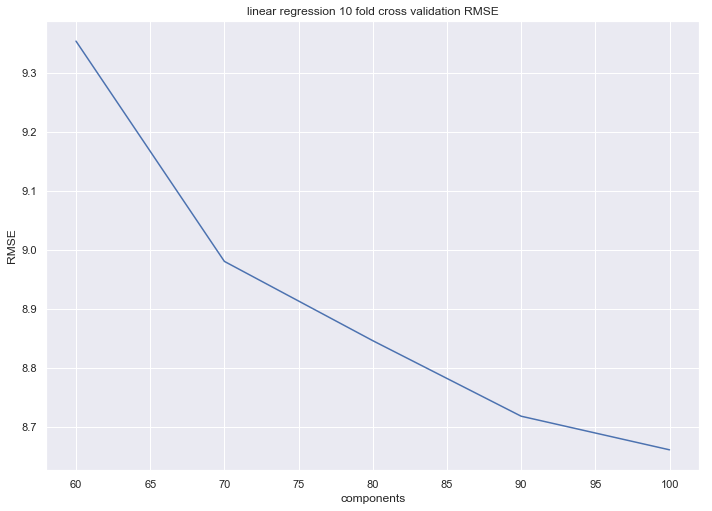

the best result is for  100 components with RMSE =  8.660491972363364  and R^2 =  0.46341300859670265


In [79]:
r2=[0 for i in range(5)]
rmse=[0 for i in range(5)]
components = [i for i in range(60,110,10)]

for i in tqdm(range(5)):
    pca = PCA(n_components=components[i])
    X_pca = pca.fit_transform(X)
    lm = linear_model.LinearRegression()
    score = cross_val_score(lm, X_pca, Y, cv=10, scoring='neg_mean_squared_error')
    rmse[i] = np.sqrt(score.mean()*-1)
    lm.fit(X_pca,Y)
    r2[i] = lm.score(X_pca,Y)
    
plt.plot(components,r2)
plt.ylabel('R^2')
plt.xlabel('components')
plt.title('linear regression R^2')
plt.show()

plt.plot(components,rmse)
plt.ylabel('RMSE')
plt.xlabel('components')
plt.title('linear regression 10 fold cross validation RMSE')
plt.show()

best = np.argmin(rmse)
print("the best result is for ",components[best] , "components with RMSE = ", rmse[best], " and R^2 = ", r2[best])

Again we can see that the RMSE decreases as we use more components, that is returning to the original dimension. 
<br>
Since it is clear that the new features did improve the overall performers, they are correlated to the response and there is no redundancy of features, we now change our strategy and try to add even more informative features while handling regularization and dimensionality reduction in other ways.

## Feature Engineering
We go back to add more fetures. 
<br>
__Feature Engineering__:
<br>
- _contention score_ - probability of reaching the playoffs given the teams rank in the division, current win record and number of games left to the season. (numeric)

__Integrations__: 
<br>
- _ticket price_  - average regular game ticket price (USD not adjusted for inflation) for that team/season. Normalized against average ticket prices for all teams in each season (numeric)
<br>
- _player age_  - 2 new features (for each team): average and max player's age. when age is the total number of games to date a player has appeared in an opening lineup. Normalized against player ages for all players/games. (numeric)

In [80]:
# @hidden cell
bin_gt_cache = {}

def nCr(n,r):
    f = math.factorial
    if n<r:
        return 0
    return f(n) / f(r) / f(n-r)

def bin(n,p,k):
    return nCr(n,k)*p**k*(1-p)**(n-k)

def bin_gt(n,p,k):
    # to save time return obvious results..
    if k==0:
        return 1
    if k>n:
        return 0
    if (n,p,k) not in bin_gt_cache:
        bin_gt_cache[n, p, k] = sum(bin(n,p,i) for i in range(k,n+1))
    return bin_gt_cache[n, p, k]

def contention_score(df):
    """
    calculate probability of reaching the playoffs given the teams rank in the division,
    current win record and number of games left to the season.
    """
    for r in df:
        for team in ['home_team', 'visiting_team']:
            if r[team+'_game_number'] <= 10: # not enough games played in the season. default to 0.5
                r[team + '_contention_score'] = 0.5
            else:
                pct = 1-round(r[team+'_loss_count']*1.0/(r[team+'_game_number']-1) if r[team+'_game_number'] > 1 else 0.5,3)
                gr = 163 - int(r[team+'_game_number']) # games remaining
                gb = r[team+'_games_behind'] # games behind
                contender_pct = r[team + '_contender_pct']  # winning percentage
                contender_gr = r[team + '_contender_games_remaining']

                # contention score = p(X >= Xc + gb) where X~Bin(pct,gr), Xc~Bin(contender_pct,contender_gr)
                # use p(X >= Y) = Sigma_(k=[0,n]) p(X >= k)*p(X = k)
                r[team+'_contention_score'] = sum(bin_gt(gr,pct,max(k+gb,0))*bin(contender_gr,contender_pct,k) for k in range(0,min(gr,contender_gr)+1))


def ticket_price(df):
    """
    average regular game ticket price (USD not adjusted for inflation) for that team/season.
    Normalized against average ticket prices for all teams in each season
    """
    prices = {}
    norm = defaultdict(list) # all values to be used to normalize the feature

    with open("ticket_prices.csv", encoding='utf-8-sig') as fp:
        reader = csv.DictReader(fp)
        for r in reader:
            for season, price in r.items():
                if season != 'team' and price != '':
                    prices[int(season), r['team']] = float(price)
                    norm[int(season)].append(float(price))

    norm_cache = {}
    for r in df:
        #normalize against all ticket prices for that season.
        r['avg_ticket_price_normalized'] = normalize(norm[r['season']],prices[r['season'],r['home_team']], norm_cache, r['season'])

def player_age(df):
    """
    player age = total number of games to date a player has appeared in an opening lineup.
    Normalized against player ages for all players/games.
    "Veteran" players have better name recoginition, tend to be bigger "stars" and become team icons if the have been with the team for a long time
    """
    current_ages = defaultdict(int) # holds the metric count per player up until a given point in time
    ages = {} # holds age metrics (mean,max) for each team / game
    norm = {'avg': [], 'max': []}
    with open("all_players1970_2017.csv") as fp: # load game logs 1970-2017
        reader = csv.DictReader(fp)
        for r in reader:
            dt = max(datetime.strptime(r['date'],'%m/%d/%Y').date(),date(1990,1,1)) # don't care about individual game data before 1990
            for team in ('home', 'visiting'):
                if dt > date(1990, 1, 1):
                    current_team_ages = [current_ages[r['{}_player{}_id'.format(team,i)]] for i in range(1,10)] #get current age for each player in lineup
                    current_team_age_mean = mean(current_team_ages)
                    current_team_age_max = max(current_team_ages)
                    ages[dt, r[team+'_team'], 'avg'] = current_team_age_mean
                    ages[dt, r[team+'_team'], 'max'] = current_team_age_max
                    norm['avg'].append(current_team_age_mean)
                    norm['max'].append(current_team_age_max)
                for i in range(1,10):
                    current_ages[r['{}_player{}_id'.format(team,i)]]+=1 # update ages for all players in this game's lineup

    norm_cache = {}
    for r in df:
        for team in ('home_team', 'visiting_team'):
            r[team+'_average_player_age_normalized'] = normalize(norm['avg'], ages[r['date'], r[team], 'avg'], norm_cache, 'avg')
            r[team+'_max_player_age_normalized'] = normalize(norm['max'], ages[r['date'], r[team], 'max'], norm_cache, 'max')



In [81]:
data_as_dict = data.to_dict("records")
contention_score(data_as_dict)
ticket_price(data_as_dict)
player_age(data_as_dict)
data = pd.DataFrame().from_records(data_as_dict)

data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]

## Modeling
### attempts to reduce dimensionality

#### different model for each home team

In [82]:
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))

# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# one-hot encoding for the visiting team
oh_visiting_team = pd.get_dummies(data_for_modeling['visiting_team'],prefix='visiting_team')

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# one-hot encoding for the team's division
oh_visiting_team_division = pd.get_dummies(data_for_modeling['visiting_team_division'],prefix='visiting_team_division')
oh_home_team_division = pd.get_dummies(data_for_modeling['home_team_division'],prefix='home_team_division')

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

# one-hot encoding for the park ids
oh_park_id = pd.get_dummies(data_for_modeling['park_id'],prefix='park_id')

post_game_features_and_players.remove('home_team')

X = data_for_modeling.drop(post_game_features_and_players,axis=1)
X = pd.concat([X,oh_visiting_team,oh_visiting_team_division,oh_home_team_division,oh_park_id],axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [83]:
print("the dimension of data - a separate model for each team", X.shape)

the dimension of data - a separate model for each team (64836, 185)


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [09:13<00:00, 18.67s/it]


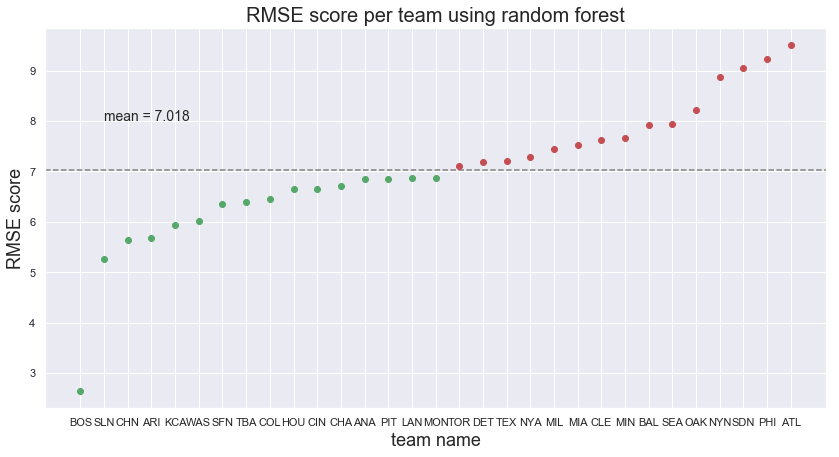

In [84]:
list_of_teams = list(set(X['home_team']))
rmse_per_team = [0 for i in range(len(list_of_teams))]
r2_per_team = [0 for i in range(len(list_of_teams))]
for i in tqdm(range(len(list_of_teams))):
    df_per_team = X[X['home_team'] == list_of_teams[i]]
    Y_per_team = df_per_team['attendance_in_thousands']
    X_per_team = df_per_team.drop(['attendance_in_thousands','home_team'], axis = 1)
    rdfr = RandomForestRegressor(n_estimators = 20)
    score = cross_val_score(rdfr, X_per_team, Y_per_team, cv=10, scoring='neg_mean_squared_error')
    rmse_per_team[i] = np.sqrt(score.mean()*-1)
    rdfr.fit(X_per_team,Y_per_team)
    r2_per_team[i] = rdfr.score(X_per_team,Y_per_team)

#sort by rmse values and plot
new_df = pd.DataFrame({'team':list_of_teams, 'rmse':rmse_per_team, 'r2':r2_per_team})
new_df = new_df.sort_values(by = ['rmse'])
sort_rmse = new_df.rmse.tolist()
mean = new_df['rmse'].mean()
#mask above and below the mean 
mask_above = ma.masked_less(sort_rmse, mean)
mask_below = ma.masked_greater(sort_rmse, mean)
plt.figure(figsize = (14,7))
plt.axhline(y=mean, color='gray', linestyle='--')
plt.plot(new_df['team'], mask_above,'ro' )
plt.plot(new_df['team'], mask_below, 'go')
plt.ylabel('RMSE score', fontsize = 18)
plt.xlabel('team name',fontsize = 18)
textstr ="mean = " +str("%.3f" % mean)
plt.text(1, int(mean)+1, textstr, fontsize =14)
plt.title('RMSE score per team using random forest', fontsize =20)

plt.show()


There is a high variation between the performers on different teams. For example, the model for team 'BOS' is very good while the one for the team 'CLE' is among the poor models. This makes sense when we remember the differences in attendece's distributions between the two teams as was shown earlier in the database analysis process.

Since the models are not stable, we go back to creating one model for the entire data.

#### using trees based methods - Random forest
In order to reduce dimensionality, we will not use one hot encoding, instead we use methods that can handle categorical variables.

In [85]:
data_for_modeling = data[data['attendance']!=0]
data_for_modeling = data_for_modeling[data_for_modeling.attendance.notnull()]
data_for_modeling['attendance_in_thousands'] = data_for_modeling['attendance'].apply(lambda x: int(round(x, -3)/1000))
# treat the days as categorial data 
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].astype('category')
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.reorder_categories(['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], ordered=True)
data_for_modeling['day_of_week'] = data_for_modeling['day_of_week'].cat.codes

# treat the leagues as categorial data 
cats = data_for_modeling[['visiting_team_league','home_team_league']].stack().sort_values().unique()
data_for_modeling['visiting_team_league'] = pd.Categorical(data_for_modeling['visiting_team_league'], categories=cats)
data_for_modeling['home_team_league'] = pd.Categorical(data_for_modeling['home_team_league'], categories=cats)
data_for_modeling[['visiting_team_league','home_team_league']] = data_for_modeling[['visiting_team_league','home_team_league']].apply(lambda x: x.cat.codes)

# treat the game time as categorial data 
data_for_modeling['game_time'] = data_for_modeling['game_time'].astype('category')
data_for_modeling['game_time'] = data_for_modeling['game_time'].cat.codes

#do not drop the features that we used to one-hot
post_game_features_and_players.remove('visiting_team')
post_game_features_and_players.remove('visiting_team_division')
post_game_features_and_players.remove('home_team_division')
post_game_features_and_players.remove('park_id')

X = data_for_modeling.drop(post_game_features_and_players,axis=1)
#convert the date to date type
X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(datetime.toordinal)

In [86]:
print("final dimension of data (no one hot encoding)", X.shape)

final dimension of data (no one hot encoding) (64836, 90)


In [89]:
h2o.init()
h2oData = h2o.H2OFrame(X)
train,test = h2oData.split_frame(ratios=[0.8], seed = 1)
model = H2ORandomForestEstimator(nfolds=10, stopping_metric="RMSE", seed = 1)
training_columns = h2oData.columns
training_columns.remove('attendance_in_thousands')
response_column = 'attendance_in_thousands'
model.train(x=training_columns, y=response_column, training_frame=train)
performance = model.model_performance(test_data=test)

print (performance)
print ("R2: " + str(model.r2()))
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\Users\elkana\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\elkana\AppData\Local\Temp\tmpwt1szp5k
  JVM stdout: C:\Users\elkana\AppData\Local\Temp\tmpwt1szp5k\h2o_elkana_started_from_python.out
  JVM stderr: C:\Users\elkana\AppData\Local\Temp\tmpwt1szp5k\h2o_elkana_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,Asia/Jerusalem
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_elkana_h5gu93
H2O cluster total nodes:,1
H2O cluster free memory:,1.754 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 26.353988946401184
RMSE: 5.1336136343126935
MAE: 3.7786549844919293
RMSLE: 0.1977002904821377
Mean Residual Deviance: 26.353988946401184

R2: 0.777957341879252
H2O session _sid_a877 closed.


#### Gradient Boosting
our final attempt is to include boosting instead of bagging (random forest) in order to increase predictive force and to decrease bias.

In [92]:
h2o.init()
h2oData = h2o.H2OFrame(X)
train,test = h2oData.split_frame(ratios=[0.8], seed = 1)
grb = H2OGradientBoostingEstimator(ntrees=500, nfolds = 10, stopping_tolerance=0.06,balance_classes = True, seed = 1,
                                   stopping_metric = "rmse")
training_columns = h2oData.columns
training_columns.remove('attendance_in_thousands')
response_column = 'attendance_in_thousands'
grb.train(x=training_columns, y=response_column, training_frame=train)
performance = grb.model_performance(test_data=test)

print (performance)
print ("R2: " + str(grb.r2()))


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,16 mins 49 secs
H2O cluster timezone:,Asia/Jerusalem
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_elkana_k0nmzt
H2O cluster total nodes:,1
H2O cluster free memory:,1.671 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 22.423580404280433
RMSE: 4.735354306097953
MAE: 3.46704167385258
RMSLE: 0.1791375350456192
Mean Residual Deviance: 22.423580404280433

R2: 0.8936686573734259


## statistical evaluation

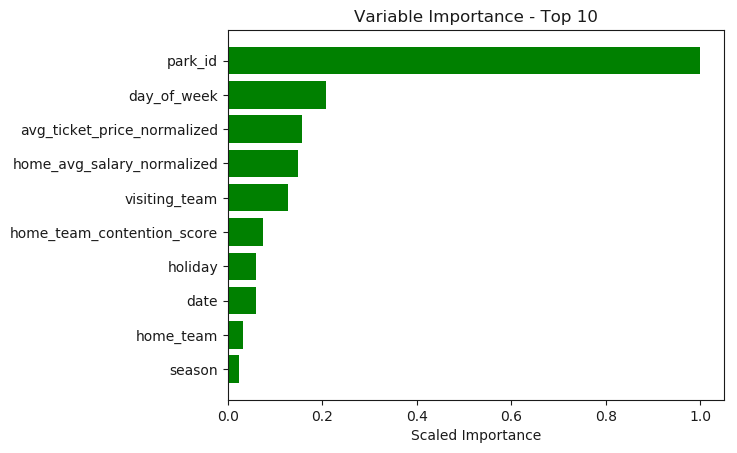

H2O session _sid_a823 closed.


In [93]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = grb._model_json['output']['variable_importances']['variable'][:10]
y_pos = np.arange(len(variables))
scaled_importance = grb._model_json['output']['variable_importances']['scaled_importance'][:10]
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance - Top 10')
plt.show()

h2o.cluster().shutdown()

## conclusion

Our best and final model is Gradient Boosting of trees that can handle categorical variables. 
<br>
The model uses a high number of tree but also a high stopping tolerance (helps to reduce overfitting). 
<br>
We hope you enjoyed reading the notebook as much as we enjoyed creating it. 
<br>
See you at the next baseball game! 
